# micapipe v0.2.0 | Group QC

In [140]:
from xhtml2pdf import pisa
import sys
import pandas as pd
import numpy as np
import os
import glob
import json
import nibabel as nb
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres

# Set dataset PNI as working directory
os.chdir(out)

# Load native mid surface
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
inf_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', vmin=None, vmax=None,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0):
    
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = plt.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=vmin, vmax=vmax, xticklabels=xticklabels, yticklabels=yticklabels)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)
    # Rotate the x-axis labels
    # rotate tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xrot, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=yrot, ha='right')


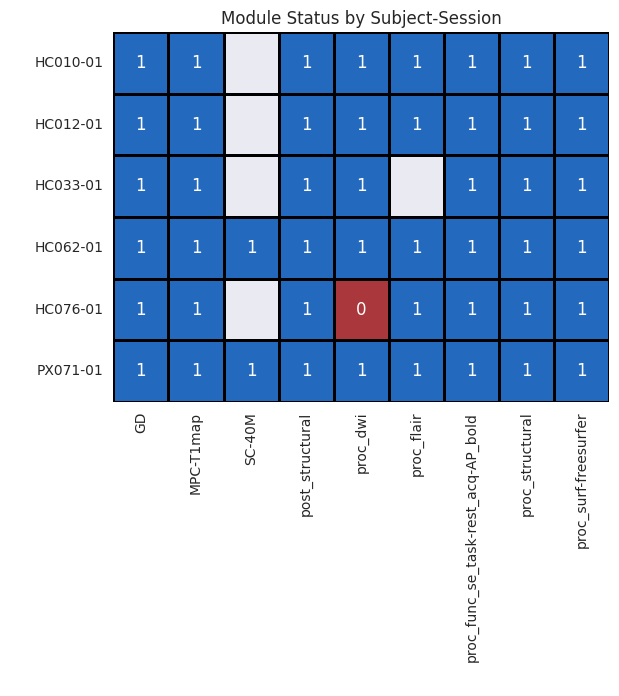

In [148]:
# Arguments
sub = 'HC062'
# out = '/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'
# bids = '/data_/mica3/BIDS_PNI/rawdata'
out = '/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
bids = '/data_/mica3/BIDS_MICs/rawdata'
ses = '01'
tmpDir = '/tmp/'
version = 'v0.2.0'

# Optional inputs:
# Session
if ses == "":
    ses_number = "Not defined"
    sbids = sub
else:
    ses_number = ses
    ses = "ses-" + ses_number
    sbids = sub + "_" + ses

derivatives = out.split('/micapipe_v0.2.0')[0]

# Path to MICAPIPE
MICAPIPE=os.popen("echo $MICAPIPE").read()[:-1]

# List all the jsons
if ses_number == "Not defined":
    jsons = sorted(glob.glob(out+'/sub*/QC/*json'))
else:
    jsons = sorted(glob.glob(out+'/sub*/ses*/QC/*json'))

# Sort the JSON files by creation time (newest at the bottom)
jsons = sorted(jsons, key=lambda x: os.path.getctime(x))
                   
# Define the keys to extract from each JSON file
keys_to_extract = ['Subject', 'Session', 'Module', 'Status', 'Progress', 'User', 'Workstation', 'Date', 'Processing.time', 'Processing', 'micapipeVersion']

# Initialize an empty list to hold the individual dataframes
dataframes = []

# Loop through each JSON file in the specified directory
for file_name in jsons:

    # Read in the JSON data from the file
    with open(file_name, 'r') as f:
        json_data = json.load(f)

    # Extract the desired keys and create a dataframe
    data = {k: [] for k in keys_to_extract}
    
    for k in keys_to_extract:
        data[k].append(json_data[k])

    df = pd.DataFrame(data)

    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the individual dataframes into a single dataframe
result = pd.concat(dataframes, ignore_index=True)

# Rename Version column
result.rename(columns={'micapipeVersion': 'Version'})

# Save the resulting dataframe as a CSV file
result.to_csv(out+'/micapipe_processed_sub.csv', index=False)

# --------------------------------------------------------
# Create an empty dictionary to hold the data
data = {}

# Loop through each row in the concatenated dataframe
for i in range(len(result)):

    # Extract thesubject and session and module and status from the row
    subject = result['Subject'][i]
    session = result['Session'][i]
    module = result['Module'][i]
    status = result['Status'][i]

    # Convert the status to a binary value
    if status == 'INCOMPLETE':
        value = 0
    elif status == 'COMPLETED':
        value = 1
    else:
        value = np.nan

    # Add the value to the data dictionary
    key = f"{subject}-{session}"
    if key not in data:
        data[key] = {}
    data[key][f"{module}"] = value

# Create a dataframe from the data dictionary
df = pd.DataFrame(data).T

# Sort the columns by module and status
df = df.reindex(sorted(df.columns), axis=1)

# Sort the rows by subject and session
df = df.sort_index()

import seaborn as sns
import matplotlib.pyplot as plt

# background
sns.set_style('dark')
sns.heatmap(df, cmap='vlag_r', annot=True, cbar=False, fmt='.0f', linewidths=1, linecolor='black', annot_kws={'fontsize':12, 'color':'white'})

# Set the x and y axis labels to white
plt.xlabel('Module-Status', fontsize=14, color='white')
plt.ylabel('Subject-Session', fontsize=14, color='white')

# Set the plot title and axis labels
plt.title('Module Status by Subject-Session')
plt.xlabel('Module-Status')
plt.ylabel('Subject-Session')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.show()

In [149]:
# Get progress percentage
module_progress = np.sum(df, axis=0)/len(df)

Text(0.5, 1.0, 'Module Progress')

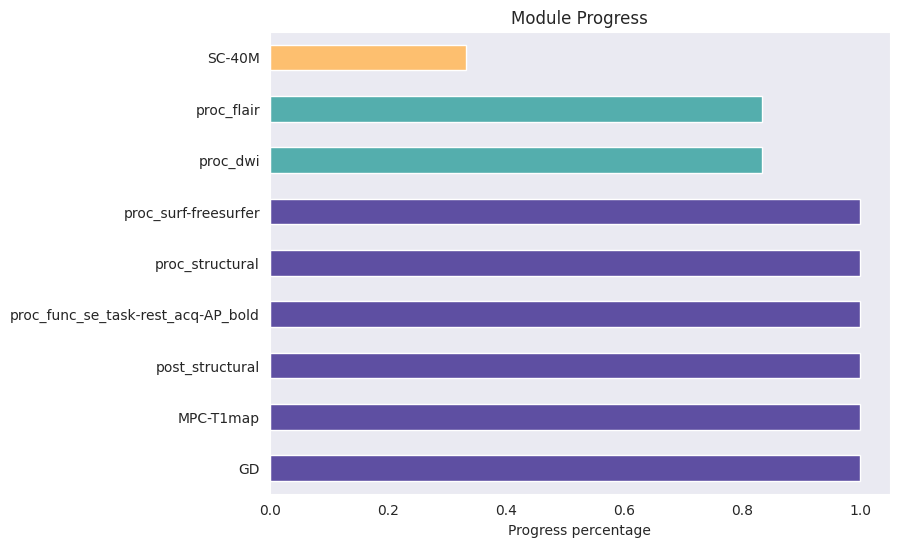

In [150]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import Spectral

# sort the series by values
module_progress_sorted = module_progress.sort_values(ascending=False)

# create the horizontal barplot
fig, ax = plt.subplots(figsize=(8, 6))
module_progress_sorted.plot.barh(ax=ax, color=Spectral(module_progress_sorted))

# set the x and y axis labels and title
ax.set_xlabel('Progress percentage')
ax.set_title('Module Progress')


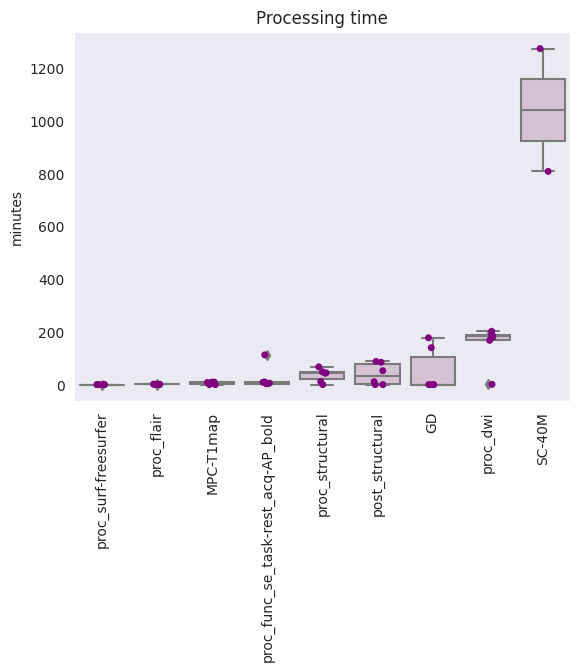

In [154]:
# Convert the processing.time to numeric
result['Processing.time'] = pd.to_numeric(result['Processing.time'])

# Calculate the mean and standard deviation by module and sort by mean processing time
stats_df = result.groupby('Module')['Processing.time'].agg(['mean', 'std'])
stats_df = stats_df.sort_values('mean')
stats_df['mean_std'] = stats_df.apply(lambda row: '{:.2f} +/- {:.2f}'.format(row['mean'], row['std']), axis=1)
stats_df = stats_df.reset_index()

# Create the box plot with custom box and whisker colors and sorted order
sns.boxplot(x='Module', y='Processing.time', data=result, order=stats_df['Module'], color='thistle')

# Add the individual data points as dots
sns.stripplot(x='Module', y='Processing.time', data=result, order=stats_df['Module'], color='purple')

# Set the title of the plot
plt.title('Processing Time')

# Rotate the x-axis labels
plt.xticks(rotation=90)
# labels
plt.xlabel('')
plt.ylabel('minutes')
plt.title('Processing time')

# Show the plot
plt.show()

In [155]:
# Calculate the mean and standard deviation by module and sort by mean processing time
stats_df = result.groupby('Module')['Processing.time'].agg(['mean', 'std'])
stats_df = stats_df.sort_values('mean')
stats_df['mean_std'] = stats_df.apply(lambda row: '{:.1f} ± {:.1f}'.format(row['mean'], row['std']), axis=1)

# Print the table as a pandas dataframe
stats_df[['mean_std']]

,mean_std
Module,
proc_surf-freesurfer,0.0 ± 0.0
proc_flair,1.2 ± 0.7
MPC-T1map,5.5 ± 4.5
proc_func_se_task-rest_acq-AP_bold,24.0 ± 43.6
proc_structural,35.9 ± 25.1
post_structural,39.4 ± 41.2
GD,52.9 ± 82.9
proc_dwi,154.2 ± 75.9
SC-40M,1041.7 ± 329.4


# Thickness group level cortical thickness

In [144]:
# Load all the cortical thickness
th_lh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-thickness.func.gii'))
th_rh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-thickness.func.gii'))

# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in th_lh_files]

# Load all the thickness data
Nth=np.concatenate((nb.load(th_lh_files[0]).darrays[0].data, nb.load(th_rh_files[0]).darrays[0].data), axis=0).shape[0]

th=np.empty([len(th_lh_files), Nth], dtype=float)
for i, f in enumerate(th_lh_files):
    #print(f)
    th[i,:] = np.hstack(np.concatenate((nb.load(th_lh_files[i]).darrays[0].data, nb.load(th_rh_files[i]).darrays[0].data), axis=0))

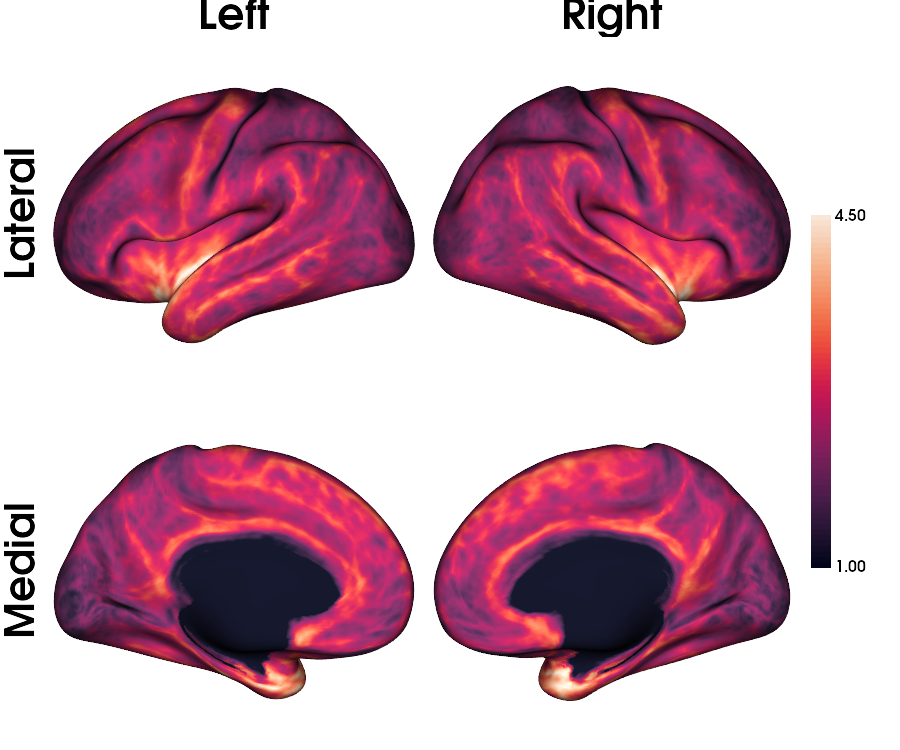

In [145]:
# Mean matrix across the x axis (vertices)
thmean = np.mean(th, axis=0)

# Plot the mean thickness 10mm on conte69 surface
plot_hemispheres(inf_lh, inf_rh, array_name=thmean, cmap='rocket', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(1, 4.5),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_thickness_mean.png')

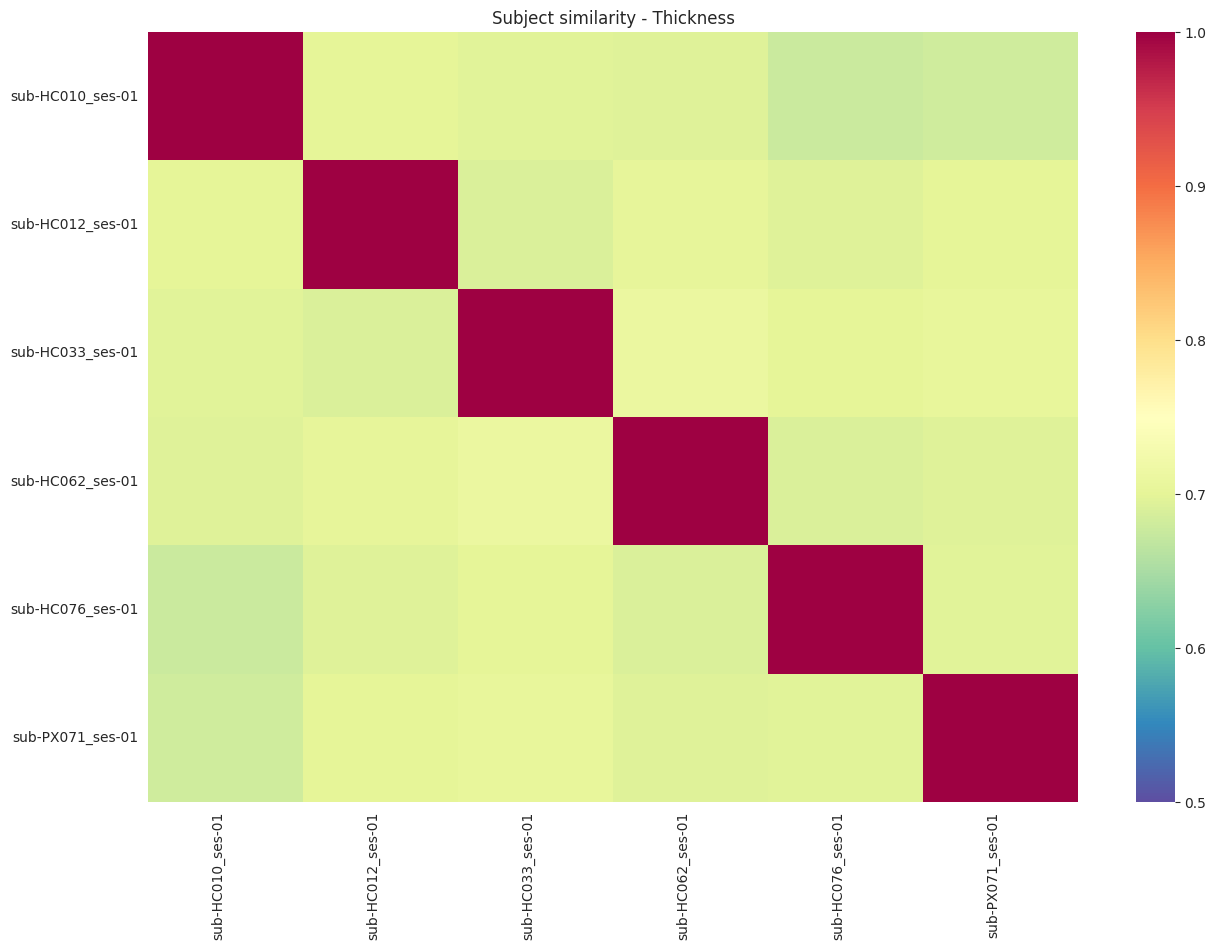

In [147]:
## correlation matrix
th_corr = np.corrcoef(th)
plot_connectome(th_corr, 'Subject similarity - Thickness', xlab=None, ylab=None, col='Spectral_r', vmin=0.5, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


# Geodesic Distance

# DWI maps

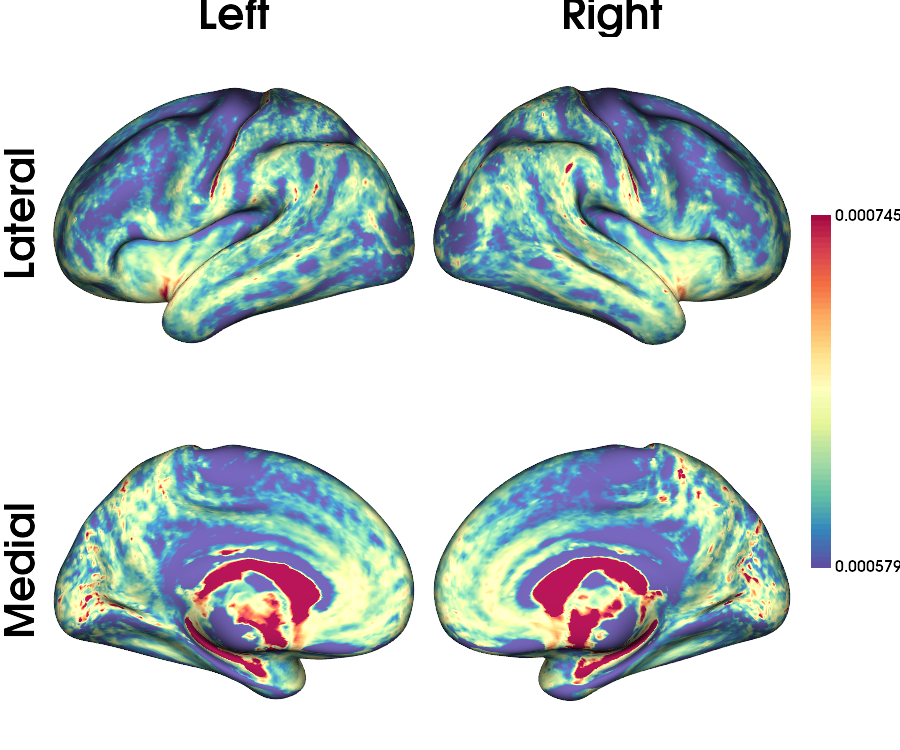

In [162]:
# Load all the cortical thickness
Map='ADC'
fl_lh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-midthickness_'+Map+'.func.gii'))
fl_rh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-midthickness_'+Map+'.func.gii'))

# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in fl_lh_files]

# Load all the thickness data
Nfl=np.concatenate((nb.load(fl_lh_files[0]).darrays[0].data, nb.load(fl_rh_files[0]).darrays[0].data), axis=0).shape[0]

fl=np.empty([len(fl_lh_files), Nfl], dtype=float)
for i, f in enumerate(fl_lh_files):
    fl[i,:] = np.hstack(np.concatenate((nb.load(fl_lh_files[i]).darrays[0].data, nb.load(fl_rh_files[i]).darrays[0].data), axis=0))

# Mean matrix across the x axis (vertices)
flmean = np.mean(fl, axis=0)

# Plot the mean thickness 10mm on conte69 surface
Range=(np.quantile(flmean, 0.15), np.quantile(flmean, 0.98))
plot_hemispheres(inf_lh, inf_rh, array_name=flmean, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=Range,
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_'+Map+'_mean.png')


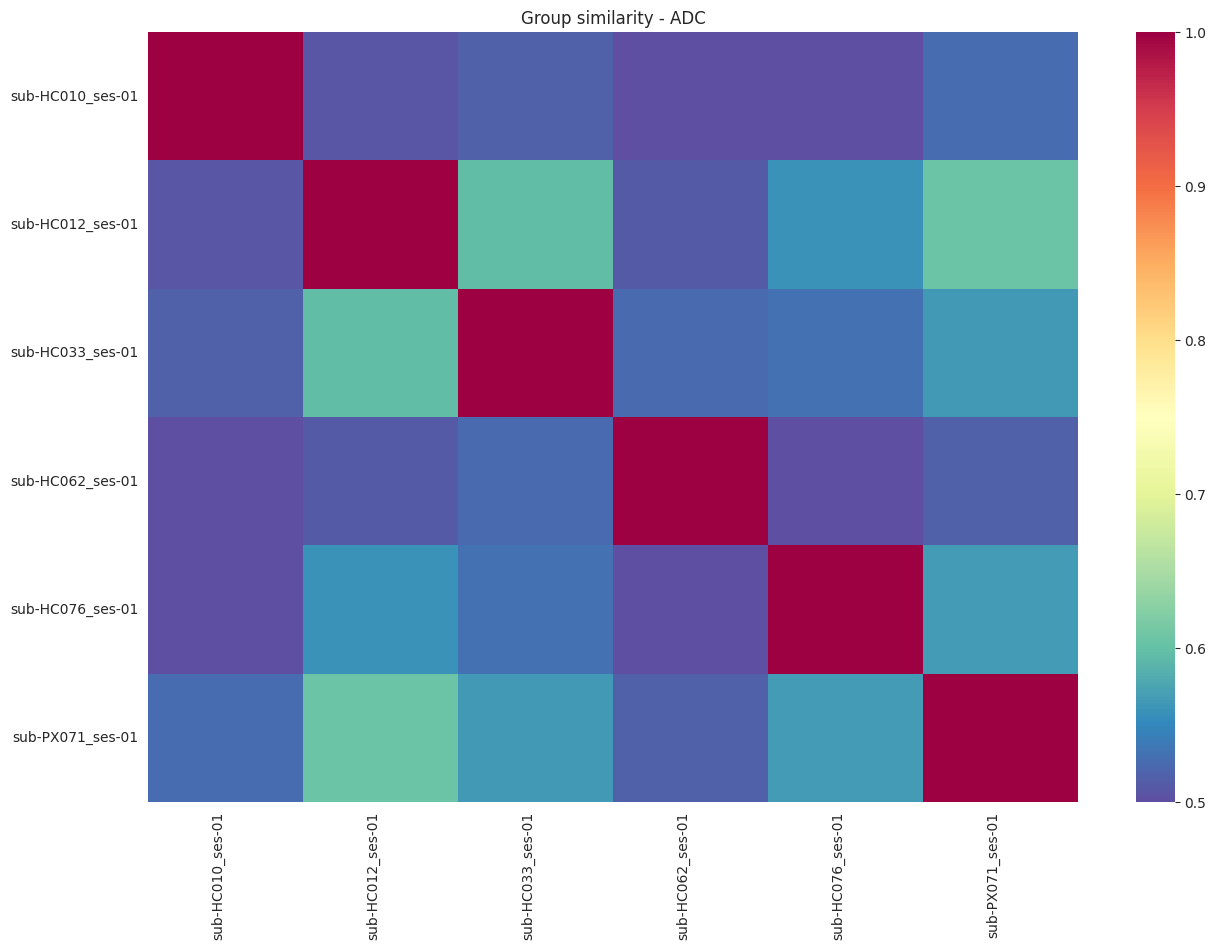

In [163]:
## correlation matrix
fl_corr = np.corrcoef(fl)
plot_connectome(fl_corr, 'Group similarity - '+Map, xlab=None, ylab=None, col='Spectral_r', vmin=0.5, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)


# SC

# proc_func

# flair

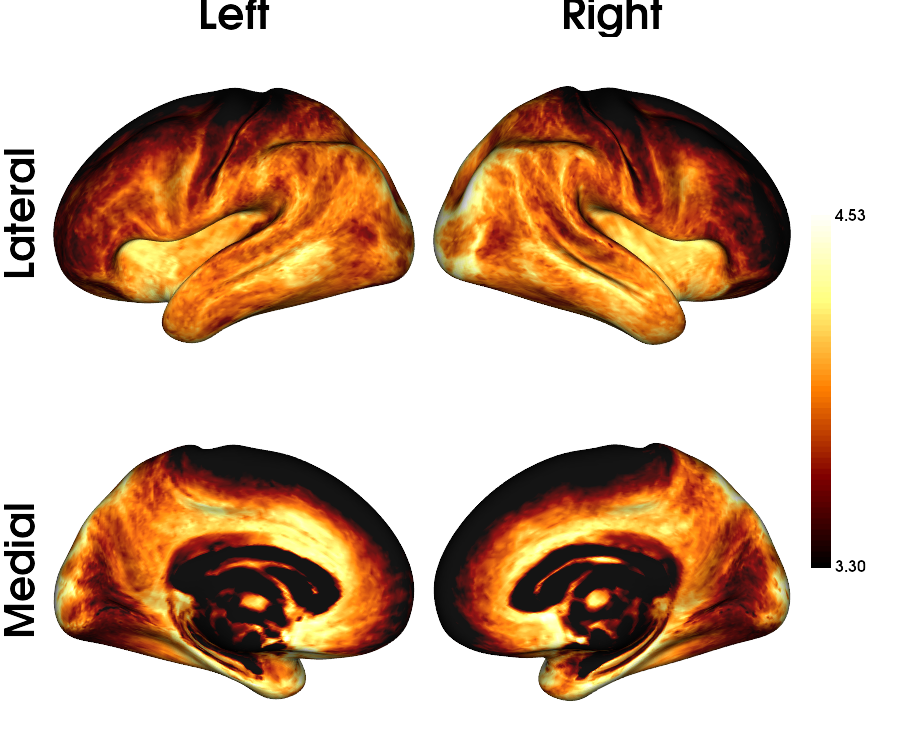

In [132]:
# Load all the cortical thickness
fl_lh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-midthickness_flair.func.gii'))
fl_rh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-midthickness_flair.func.gii'))

# get the BIDS ids
bids_ids = [elem.split('/')[0] + '_' + elem.split('/')[1] for elem in fl_lh_files]

# Load all the thickness data
Nfl=np.concatenate((nb.load(fl_lh_files[0]).darrays[0].data, nb.load(fl_rh_files[0]).darrays[0].data), axis=0).shape[0]

fl=np.empty([len(fl_lh_files), Nfl], dtype=float)
for i, f in enumerate(fl_lh_files):
    fl[i,:] = np.hstack(np.concatenate((nb.load(fl_lh_files[i]).darrays[0].data, nb.load(fl_rh_files[i]).darrays[0].data), axis=0))

# Mean matrix across the x axis (vertices)
flmean = np.mean(fl, axis=0)

# Plot the mean thickness 10mm on conte69 surface
Range=(np.quantile(flmean, 0.15), np.quantile(flmean, 0.999))
plot_hemispheres(inf_lh, inf_rh, array_name=flmean, cmap='afmhot', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=Range,
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_flair_mean.png')


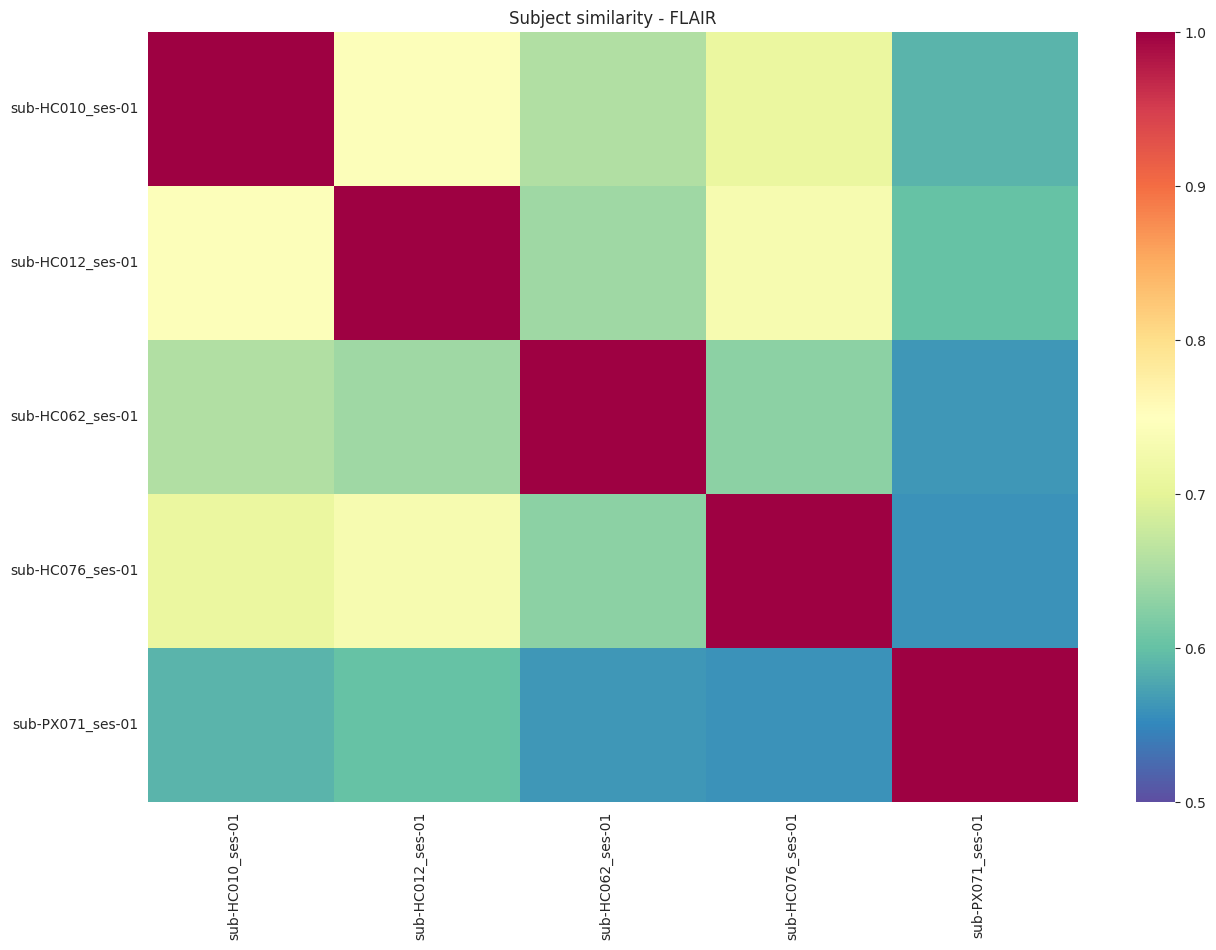

In [143]:
## correlation matrix
fl_corr = np.corrcoef(fl)
plot_connectome(fl_corr, 'Subject similarity - FLAIR', xlab=None, ylab=None, col='Spectral_r', vmin=0.5, vmax=1,
               yticklabels=bids_ids, xticklabels=bids_ids)
